In [ ]:
"""

INTEGER 32 BITS GENERATION EXPERIMENTS


We identify the PRNG use by default for machine learning technologies.
Numpy : https://numpy.org/doc/stable/reference/random/bit_generators/philox.html (use PCG64 by default)

Numpy : PCG 64 + Philox + MT

Python : https://docs.python.org/3/library/random.html (use Mersenne Twister by default)

Tensorflow : https://www.tensorflow.org/api_docs/python/tf/random/Generator  (Philox and ThreeFry, but without much information)

PyTorch : torchcsprng based on Philox ? Not sure : 
https://pytorch.org/docs/stable/generated/torch.Generator.html  
https://pytorch.org/docs/stable/torch.html#in-place-random-sampling
https://pytorch.org/blog/torchcsprng-release-blog

Scipy : Based on Numpy
Scikit-learn : Based on Numpy
…

"""


In [ ]:
"""

For Integers 32 bits : 

First, we run native experiments.
Native experiments are C codes of MT, Well, MRG32k3a and PCG32 (XSH-RR).

For each, we generate 2**30 real (0,1) random numbers.
We compile with nothing + O2 + O3, to check for performance increase.

We run 30 times each experiments to draw a confidence interval.

We measure time and energy consumption (with Powerjoular : https://gitlab.com/joular/powerjoular)

This will not take much time as C code versions are fast to generate 2**30 numbers.

Powerjoular needs SUDO

"""
!sudo ./scriptRunNativeExperiment.sh

In [ ]:
"""
Secondly, we run python experiments. (Python is the main langage used in ML)
We work on pure Python, Numpy, Tensorflow and Pytorch.

For each, we generate 2**30 real (0,1) random numbers.

We run 30 times each experiments to draw a confidence interval.

We measure time and energy consumption (with Powerjoular : https://gitlab.com/joular/powerjoular)

This will take much times.

Indeed, to generate numbers one by one, Python frameworks are really slow.
For small operations, like generating a single random number, 
the overhead of using TensorFlow or PyTorch can be high. 
However, these libraries aren't really designed for such small, isolated operations. 
They are made to work in large-scale, batched operations.

To respect initial usage and compare fairly,
we made 2 different types of experiments here: Generating 2**30 prn one by one, or at once.

Powerjoular needs SUDO

"""
!sudo ./scriptRunPythonExperiment.sh

In [ ]:
"""
Thridly, after comparing time execution and power consumption,
we want to check for numerical reproducibility, as well as PRN quality (using TestU01 big Crush).

To do so, on python code, we have to save number in file before applying Big Crush on these numbers.
Maybe it could have been possible to create a link between output of Python function and output of C function.

As TestU01 do not provide a file reading access for Big Crush, we did it ourselves.

WARNING : 
Big Crush uses close to 2**38 numbers. You will have to generate and save them in a binary file.
This will take much disk space (around 2.1T by binary file).

"""
!./scriptRunSaving.sh

In [ ]:
"""
To be sure that Big Crush on the original usage and Big Crush when reading file give the same results,
we made 3 experiment to have original Big Crush results on Mrg32k3a, Well and MT.

We will be able to compare when reading in files.
"""
!./scriptRunControlBigCrush.sh

In [ ]:
"""
We test the quality of generated PRN for all technologies, native or Python, with Big Crush
"""
!./scriptRunBigCrushTestsOnBinary.sh

###tensorflowIntegerR_tensorflowIntegerRandomGenerationAtOnce
###pytorchIntegerR_pytorchIntegerRandomGenerationAtOnce
###numpyIntegerR_numpyIntegerRandomGenerationOneByOne
###pythonIntegerR_pythonIntegerRandomGenerationAtOnce
###numpyIntegerMt_numpyIntegerMtRandomGenerationAtOnce
###numpyIntegerPhilox_numpyIntegerPhiloxRandomGenerationAtOnce
###mt19937arIntegerO2
###tensorflowIntegerTaskset_tensorflowIntegerTasksetRandomGenerationAtOnce
###mt19937arIntegerO3
###numpyIntegerMt_numpyIntegerMtRandomGenerationOneByOne
###pytorchIntegerTaskset_pytorchIntegerTasksetRandomGenerationAtOnce
###pytorchIntegerR_pytorchIntegerRandomGenerationOneByOne
###philoxIntegerR
###pythonIntegerR_pythonIntegerRandomGenerationOneByOne
###mt19937arIntegerR
###pythonIntegerTaskset_pythonIntegerTasksetRandomGenerationAtOnce
###numpyIntegerR_numpyIntegerRandomGenerationAtOnce
###numpyIntegerPhilox_numpyIntegerPhiloxRandomGenerationOneByOne
###numpyIntegerTaskset_numpyIntegerTasksetRandomGenerationAtOnce
###pcg32I

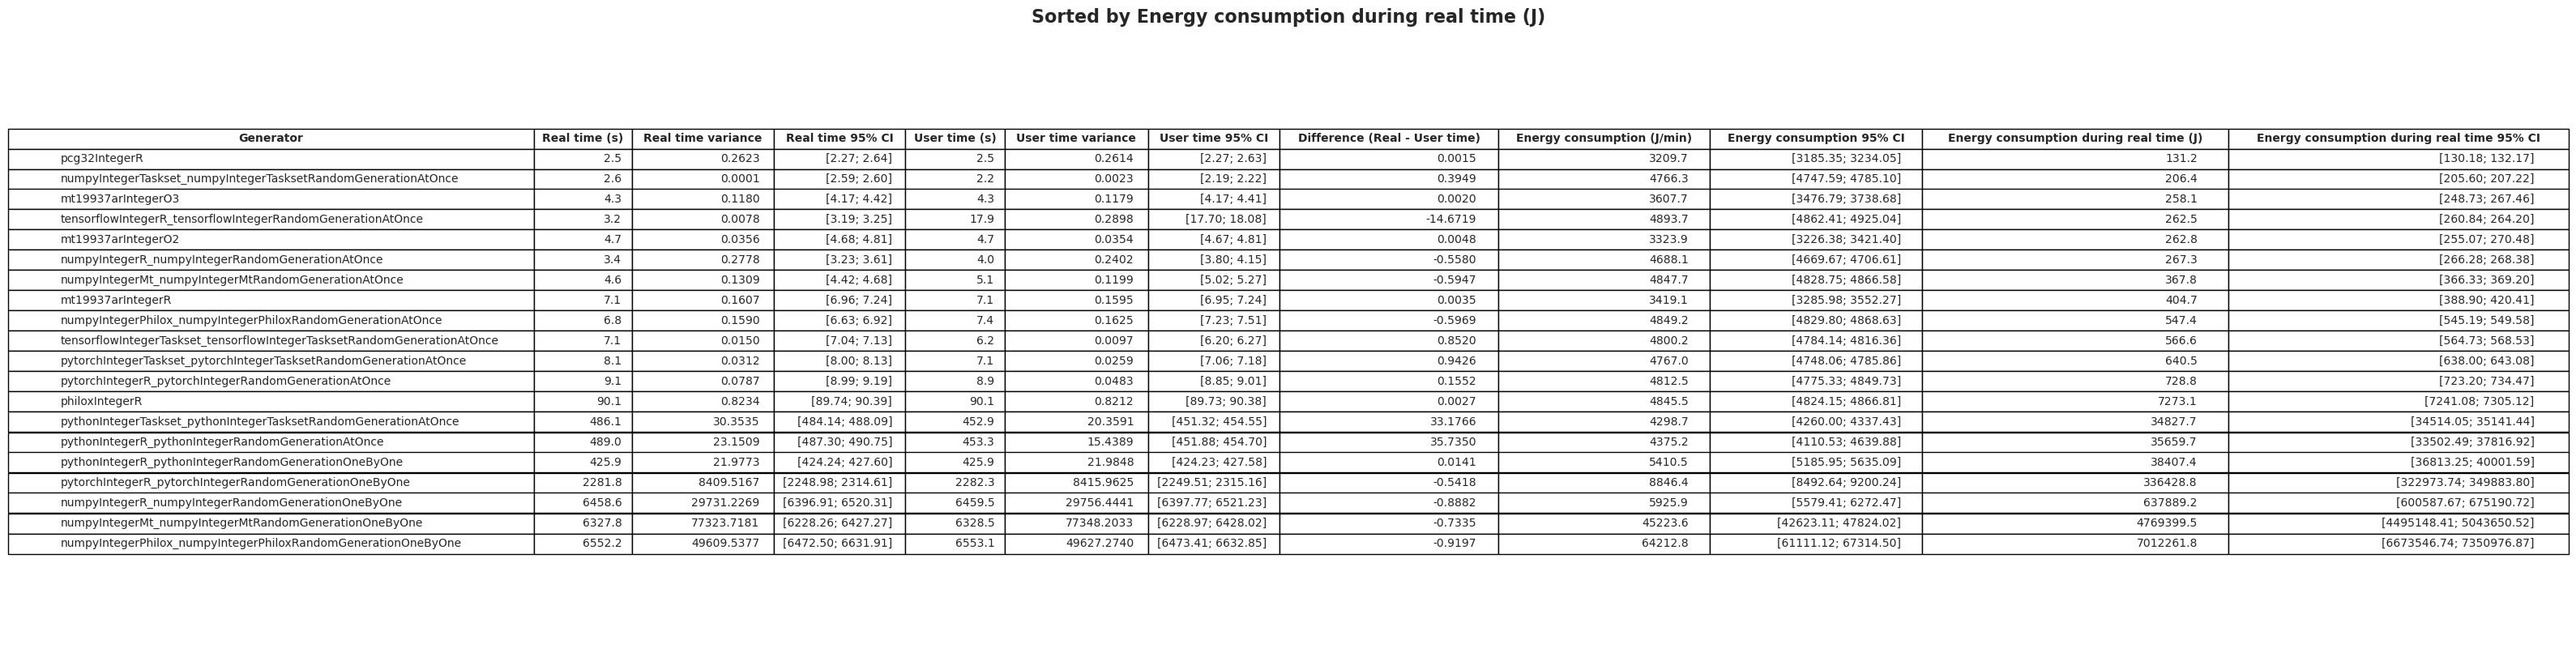

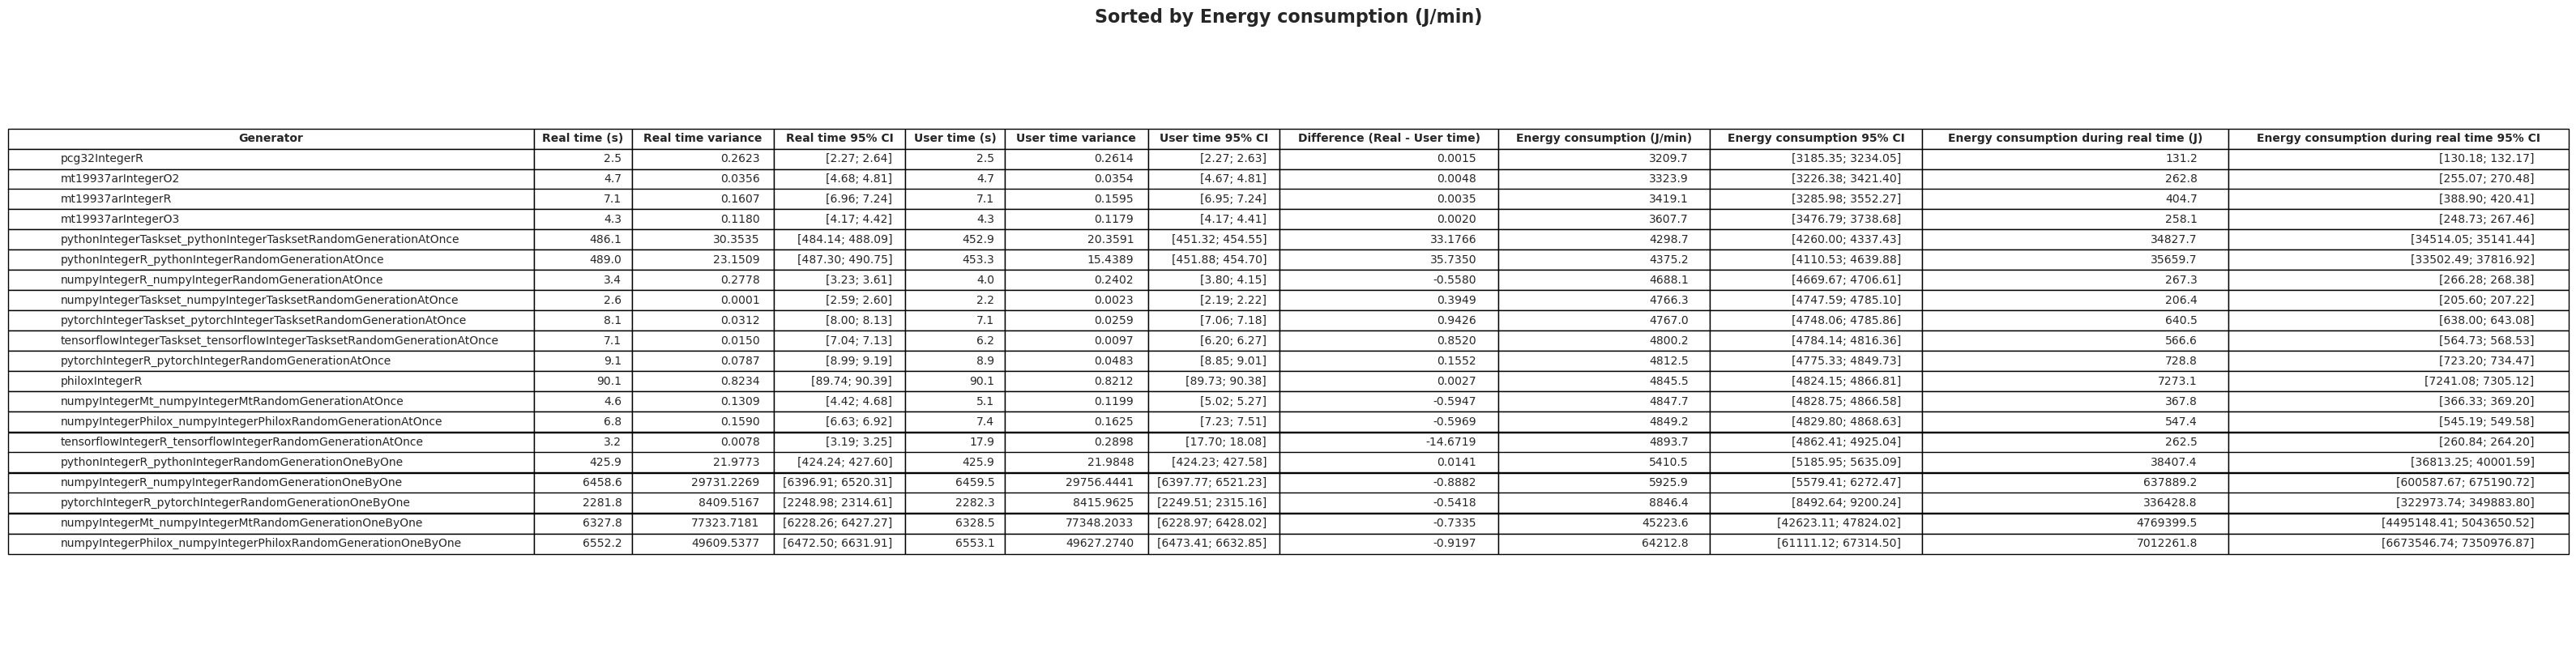

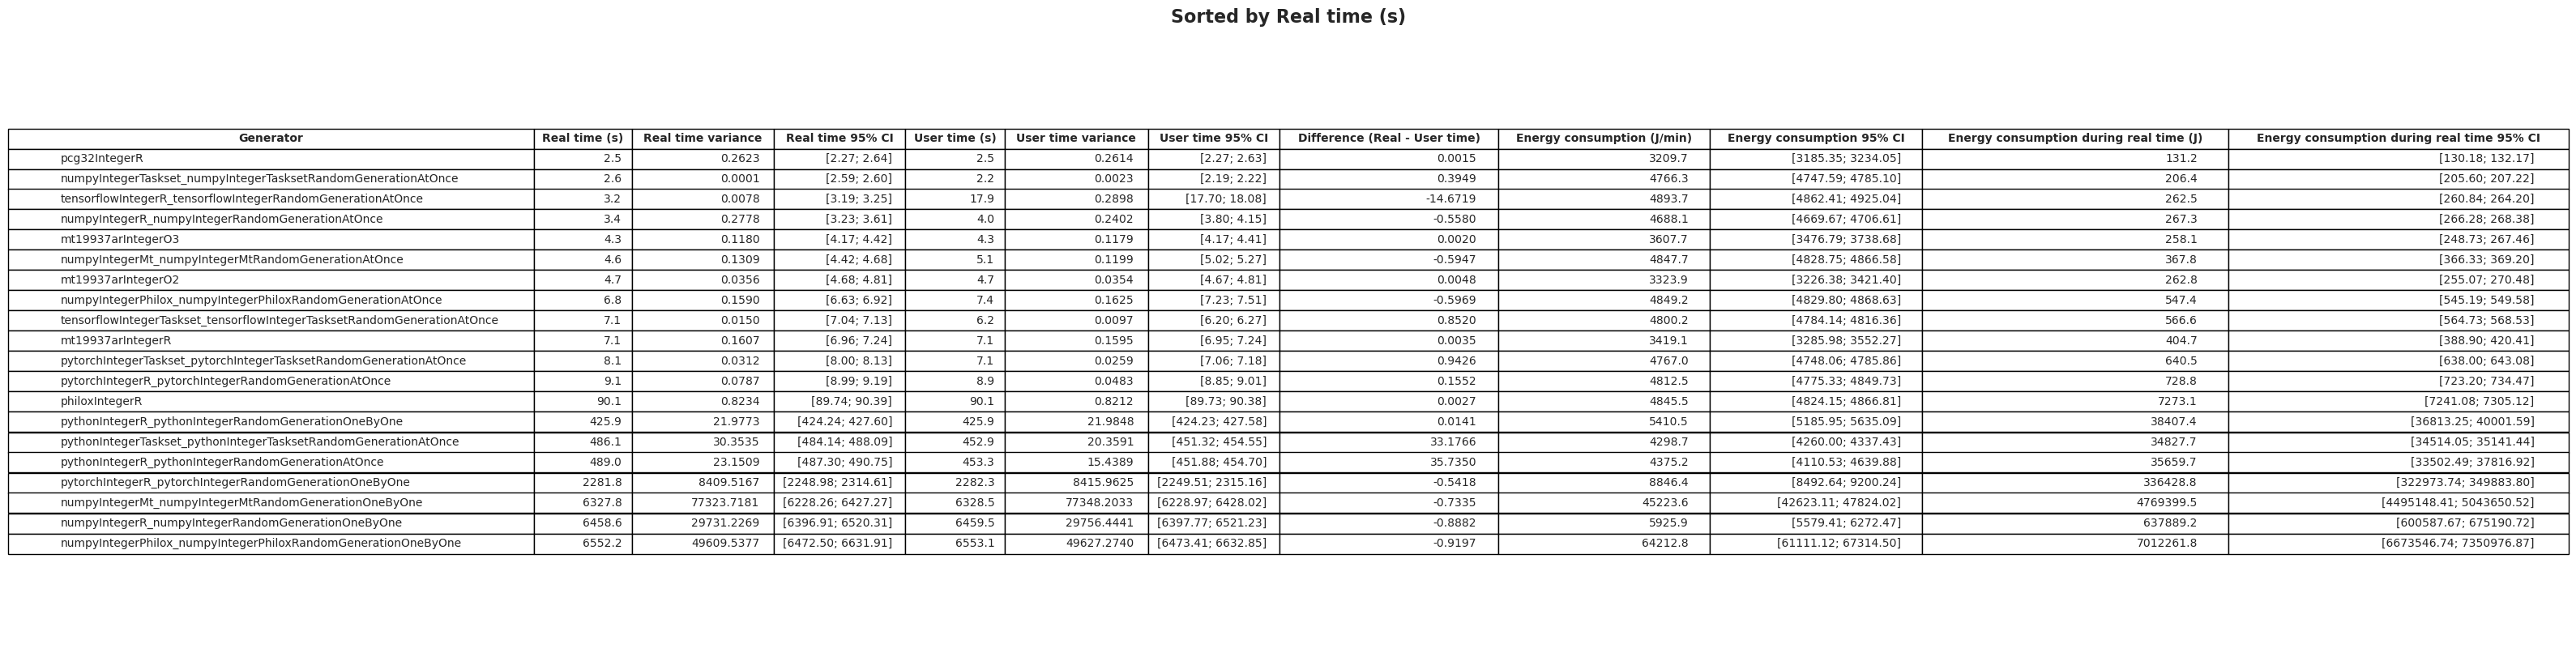

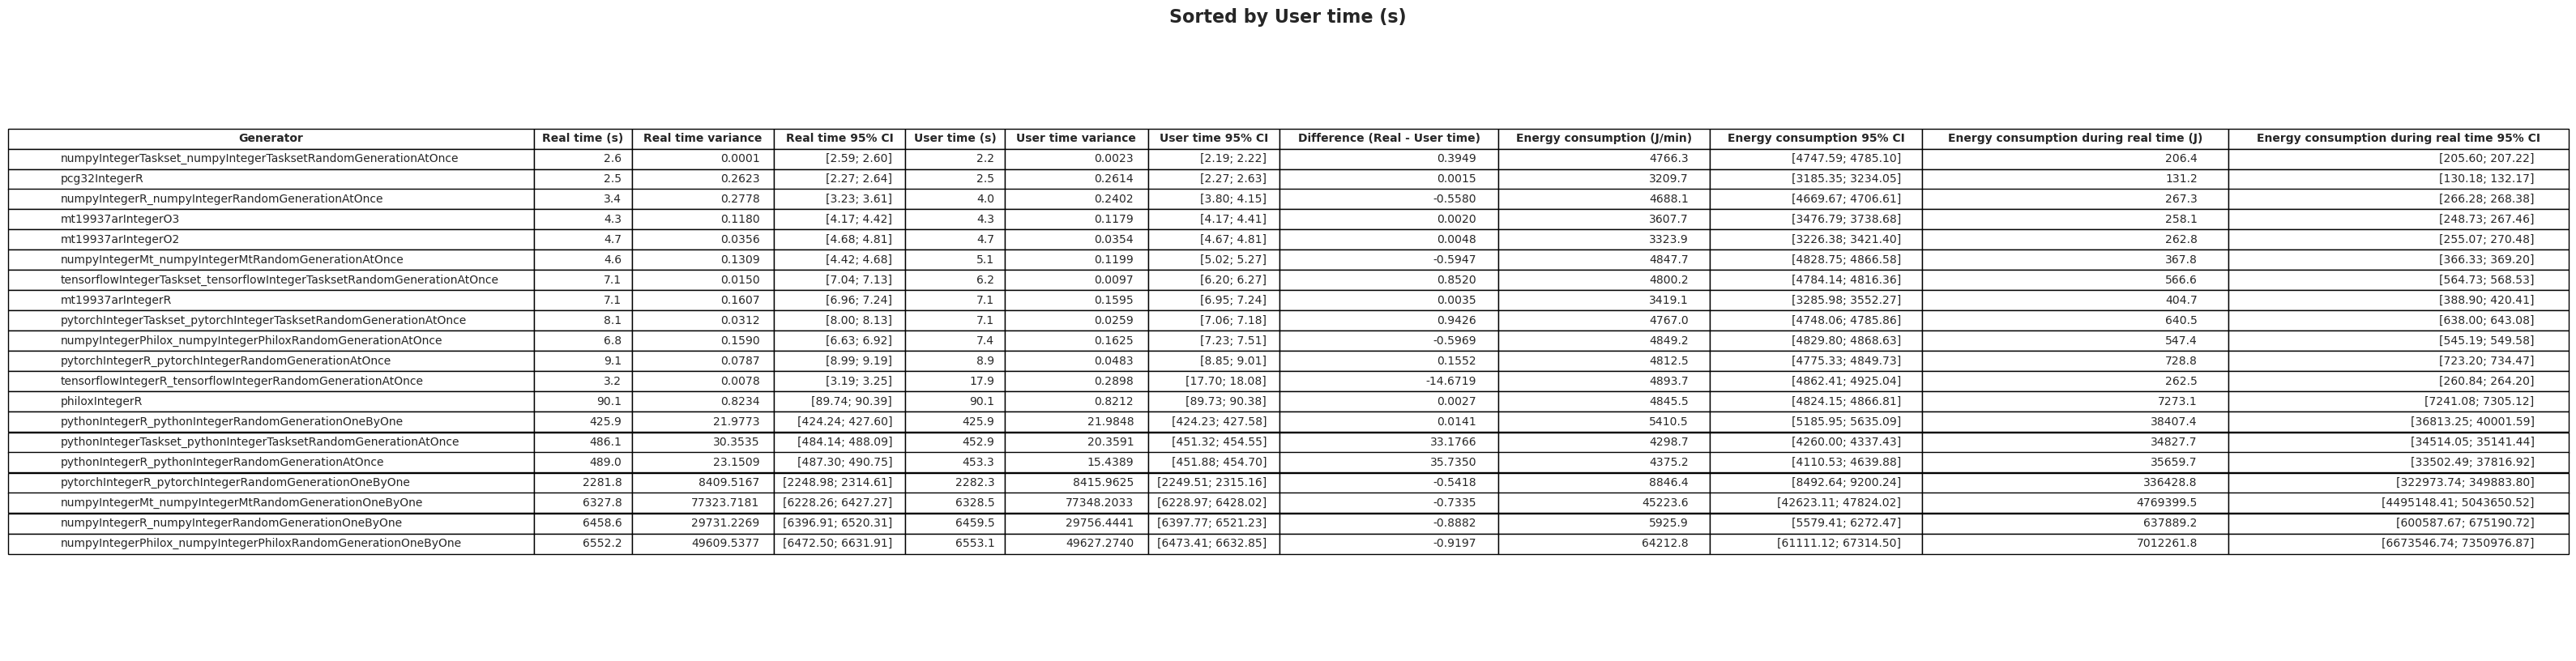

In [1]:
"""
Now, every results should be accessible.
We need to analyze those results.

Diff python vs Mt binary ? diff Numpy vs Pcg binary ?
"""
import os
import re
import statistics
import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)
import matplotlib.pyplot as plt
import seaborn as sns

# List of experiments
names = ["mt19937arIntegerR","mt19937arIntegerO2", "mt19937arIntegerO3", "pcg32IntegerR", "pcg32IntegerO2",
         "pcg32IntegerO3", "pythonIntegerR", "pytorchIntegerR","tensorflowIntegerR", "numpyIntegerR",
         "pythonIntegerTaskset", "pytorchIntegerTaskset","tensorflowIntegerTaskset","numpyIntegerTaskset",
         "numpyIntegerPhilox", "numpyIntegerMt","philoxIntegerR","philoxIntegerO2", "philoxIntegerO3"]


## TIMES : 


# Separate dictionaries for storing real and user times
real_times_dict = {}
user_times_dict = {}

# Function to extract user times and compute their average
def extract_times(contents):
    user_times = [int(minute) * 60 + float(second.replace(',', '.')) for minute, second in re.findall(r'user\s+(\d+)m([\d,]+)s', contents)]
    real_times = [int(minute) * 60 + float(second.replace(',', '.')) for minute, second in re.findall(r'real\s+(\d+)m([\d,]+)s', contents)]
    return real_times, user_times

# Loop through each file in the directory
for filename in os.listdir('.'):
    # Check if the filename starts with "time_results_"
    if filename.startswith("time_results_"):
        for name in names:
            if name in filename:
                if name in ["pythonIntegerR","numpyIntegerPhilox","numpyIntegerMt","pytorchIntegerR", "numpyIntegerR", "tensorflowIntegerR","pythonIntegerTaskset", "pytorchIntegerTaskset","tensorflowIntegerTaskset","numpyIntegerTaskset"] and ("OneByOne" in filename or "AtOnce" in filename):
                    key_name = f"{name}_{filename.split('_')[-1].split('.')[0]}" # Appends OneByOne or AtOnce to the name
                else:
                    key_name = name
                
                with open(filename, 'r') as file:
                    contents = file.read()
                    real_times, user_times = extract_times(contents)
                    if user_times:
                        print("###" + str(key_name))
                        avg_time = sum(user_times) / len(user_times)
                        user_times_dict[key_name] = avg_time
                        stdev_time = statistics.stdev(user_times)
                        # 95% confidence interval
                        margin_of_error = 1.96 * (stdev_time / (len(user_times) ** 0.5))
                        lower_bound = avg_time - margin_of_error
                        upper_bound = avg_time + margin_of_error
                        user_times_dict[key_name] = (avg_time, stdev_time, (lower_bound, upper_bound))

                    if real_times:
                        avg_time = sum(real_times) / len(real_times)
                        real_times_dict[key_name] = avg_time
                        stdev_time = statistics.stdev(real_times)
                        # 95% confidence interval
                        margin_of_error = 1.96 * (stdev_time / (len(real_times) ** 0.5))
                        lower_bound = avg_time - margin_of_error
                        upper_bound = avg_time + margin_of_error
                        real_times_dict[key_name] = (avg_time, stdev_time, (lower_bound, upper_bound))


# Print the results in alphabetical order by key
for key in sorted(real_times_dict.keys()):
    avg, stdev, (lower, upper) = real_times_dict[key]
    print(f"Average Real time for {key}: {avg:.2f} seconds, Std Dev: {stdev:.2f}, 95% Confidence Interval: [{lower:.2f}; {upper:.2f}]")

# Print the results in alphabetical order by key
for key in sorted(user_times_dict.keys()):
    avg, stdev, (lower, upper) = user_times_dict[key]
    print(f"Average User time for {key}: {avg:.2f} seconds, Std Dev: {stdev:.2f}, 95% Confidence Interval: [{lower:.2f}; {upper:.2f}]")

        
    
print("#############") 
print("#############") 
print("#############") 
print("#############") 
    
##### POWER : 

    
# Dictionary to store the average user consumption and other statistics for each experiment
average_consumption = {}

# Function to extract energy consumptions
def extract_consumptions(contents):
    energy_consumptions = [float(energy) for energy in re.findall(r'Total energy: ([\d.]+) Joules', contents)]
    return energy_consumptions

# Loop through each file in the directory
for filename in os.listdir('.'):
    # Check if the filename starts with "power_results_"
    if filename.startswith("power_results_"):
        for name in names:
            if name in filename:
                if name in ["pythonIntegerR","numpyIntegerPhilox","numpyIntegerMt","pytorchIntegerR", "numpyIntegerR", "tensorflowIntegerR","pythonIntegerTaskset", "pytorchIntegerTaskset","tensorflowIntegerTaskset","numpyIntegerTaskset"] and ("OneByOne" in filename or "AtOnce" in filename):
                    key_name = f"{name}_{filename.split('_')[-1].split('.')[0]}" # Appends OneByOne or AtOnce to the name
                else:
                    key_name = name
                
                with open(filename, 'r') as file:
                    contents = file.read()
                    consumptions = extract_consumptions(contents)
                    if consumptions:
                        avg_energy = sum(consumptions) / len(consumptions)
                        stdev_energy = statistics.stdev(consumptions)
                        # 95% confidence interval
                        margin_of_error = 1.96 * (stdev_energy / (len(consumptions) ** 0.5))
                        lower_bound = avg_energy - margin_of_error
                        upper_bound = avg_energy + margin_of_error
                        
                        """
                        I measure power consumption 30 seconds for experiment that takes long
                        I measure power consumption 4 seconds for experiment that are short
                        
                        We need to multiply by 2 or by 15 to get power consumption by minutes
                        
                        PCG 32 is too fast, so I measure during 2 seconds. (multiply by 30)
                        
                        """
                        multiplier = 2 if (("pythonIntegerR" in key_name or 
                                           "pytorchIntegerR" in key_name or 
                                           "numpyIntegerR" in key_name or 
                                           "tensorflowIntegerR" in key_name) and 
                                           "OneByOne" in key_name) else 15

                        if "pcg" in key_name:  # PCG on 32bits too fast...
                            multiplier = multiplier * 2
                        average_consumption[key_name] = (avg_energy * multiplier, stdev_energy * multiplier, (lower_bound * multiplier, upper_bound * multiplier))

# Print the results in alphabetical order by key
for key in sorted(average_consumption.keys()):
    avg, stdev, (lower, upper) = average_consumption[key]
    print(f"Average energy consumption in Joules by minutes for {key}: {avg:.2f} Joules, Std Dev: {stdev:.2f}, 95% Confidence Interval: [{lower:.2f}; {upper:.2f}]")

# Create a new DataFrame with combined confidence interval columns, including for 'Energy consumption during real time'
df = pd.DataFrame(columns=["Generator", 
                           "Real time (s)", "Real time variance", "Real time 95% CI",
                           "User time (s)", "User time variance", "User time 95% CI",
                           "Difference (Real - User time)", 
                           "Energy consumption (J/min)", "Energy consumption 95% CI",
                           "Energy consumption during real time (J)", "Energy consumption during real time 95% CI"])  # Added CI column for energy during real time

# Populate the DataFrame with combined confidence interval information
for key in sorted(user_times_dict.keys()):
    real_time_avg, real_time_stdev, (real_time_lower, real_time_upper) = real_times_dict.get(key, (0, 0, (0, 0)))
    user_time_avg, user_time_stdev, (user_time_lower, user_time_upper) = user_times_dict.get(key, (0, 0, (0, 0)))
    
    real_time_variance = real_time_stdev ** 2
    user_time_variance = user_time_stdev ** 2
    
    difference_time = real_time_avg - user_time_avg
    
    avg_energy, _, (energy_lower, energy_upper) = average_consumption.get(key, (0, 0, (0, 0)))
    energy_for_real_time = avg_energy * (real_time_avg / 60)  # Convert to minutes

    # Calculate confidence interval for energy consumption during real time
    energy_for_real_time_lower = energy_lower * (real_time_avg / 60)
    energy_for_real_time_upper = energy_upper * (real_time_avg / 60)

    # Format confidence intervals as a single string
    real_time_ci = f"[{real_time_lower:.2f}; {real_time_upper:.2f}]"
    user_time_ci = f"[{user_time_lower:.2f}; {user_time_upper:.2f}]"
    energy_ci = f"[{energy_lower:.2f}; {energy_upper:.2f}]"
    energy_for_real_time_ci = f"[{energy_for_real_time_lower:.2f}; {energy_for_real_time_upper:.2f}]"

    # Add the new formatted CI columns
    df.loc[len(df)] = [key, 
                       real_time_avg, real_time_variance, real_time_ci,
                       user_time_avg, user_time_variance, user_time_ci,
                       difference_time, 
                       avg_energy, energy_ci,
                       energy_for_real_time, energy_for_real_time_ci]

# Display the DataFrame
print(df)

# Save the DataFrame to a CSV file
df.to_csv('results_with_all_confidence_intervals.csv', index=False)




# Format all float columns of the DataFrame to have 4 decimals
for col in df.select_dtypes(include=['float64']).columns:
    df[col] = df[col].apply(lambda x: '{:.4f}'.format(x))



# Convert columns back to floats for plotting
df["Real time (s)"] = df["Real time (s)"].astype(float)
df["User time (s)"] = df["User time (s)"].astype(float)
df["Energy consumption (J/min)"] = df["Energy consumption (J/min)"].astype(float)
df["Energy consumption during real time (J)"] = df["Energy consumption during real time (J)"].astype(float)

# Function to display a dataframe as a table and save as an image
def display_and_save_table(df, filename, title=None):
    # Style setup
    df = df.round(1)
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(20, 10))  # set the size that you'd like (width, height)
    ax.axis('off')

    # Create table with default center alignment
    tab = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')

    # Consistent figure and font size
    tab.auto_set_font_size(False)
    tab.set_fontsize(10)
    tab.scale(1.5, 1.5)   # Adjust the scaling factor to fit your entries
    if title:
        ax.set_title(title, fontweight="bold", fontsize=16)

    # Auto adjust all columns
    tab.auto_set_column_width(col=list(range(len(df.columns))))  # Auto adjust all columns

    # Set the alignment for each cell
    for (i, j), cell in tab.get_celld().items():
        if i == 0:
            cell.set_text_props(fontweight='bold')
        if i > 0:
            if j == 0:
                cell.set_text_props(ha='left')  # Align left for the first column
            else:
                cell.set_text_props(ha='right')  # Align right for other columns

    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()


# Existing code to sort and save as an image
ordered_df = df.sort_values(by="Energy consumption during real time (J)", ascending=True)
display_and_save_table(ordered_df, 'table_sorted_by_energy_real_time.png', "Sorted by Energy consumption during real time (J)")
# Save the sorted and formatted DataFrame to a CSV file
ordered_df.to_csv('results_sorted_by_energy_real_time.csv', index=False)

# Repeat for other sorted DataFrames
ordered_df = df.sort_values(by="Energy consumption (J/min)", ascending=True)
display_and_save_table(ordered_df, 'table_sorted_by_energy_per_minute.png', "Sorted by Energy consumption (J/min)")
ordered_df.to_csv('results_sorted_by_energy_per_minute.csv', index=False)

ordered_df = df.sort_values(by="Real time (s)", ascending=True)
display_and_save_table(ordered_df, 'table_sorted_by_real_time.png', "Sorted by Real time (s)")
ordered_df.to_csv('results_sorted_by_real_time.csv', index=False)

ordered_df = df.sort_values(by="User time (s)", ascending=True)
display_and_save_table(ordered_df, 'table_sorted_by_user_time.png', "Sorted by User time (s)")
ordered_df.to_csv('results_sorted_by_user_time.csv', index=False)



          Generator  Number of Failed Tests  \
0       philoxInt32                       6   
1      pytorchInt32                       3   
2          pcgInt32                       1   
3           mtInt32                       2   
4      numpyMtInt32                       1   
5  numpyPhiloxInt32                       1   
6        numpyInt32                       0   
7   tensorflowInt32                       1   
8       pythonInt32                       0   

                                        Failed Tests  
0  [34 Gap,, 35 Gap,, 36 Gap,, 37 Gap,, 65 SumCol...  
1   [77 RandomWalk1, 80 LinearComp,, 81 LinearComp,]  
2                                 [5 CollisionOver,]  
3                   [80 LinearComp,, 81 LinearComp,]  
4                                   [80 LinearComp,]  
5                                       [49 MaxOft,]  
6                                                 []  
7                                 [9 CollisionOver,]  
8                                 

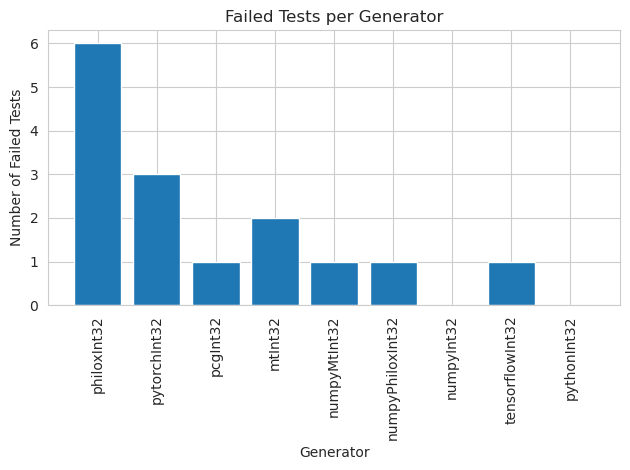

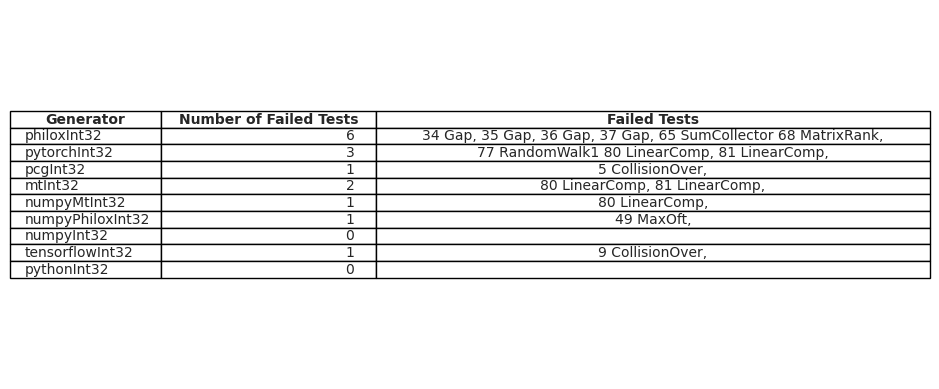

In [2]:
"""

To test numerical reproducibility of each PRNG technology, I can generate 2**20 random numbers, not as binary, and Diff files.
TestU01 is done on 2**38 numbers. We save 2**39 numbers in file.
"""

import os
import pandas as pd
import matplotlib.pyplot as plt

# Get all files that start with "bigCrush" and don't contain "Control"
file_list = [file for file in os.listdir() if file.startswith("bigCrushInteger")]

def extract_info_from_file(filename):
    with open(filename, 'r') as file:
        content = file.read()
        
        # Find the start position after "========= Summary results of BigCrush ========="
        start_idx = content.find("========= Summary results of BigCrush =========")
        
        if start_idx == -1:  # If the specified line isn't found, raise an error or return a default value
            return "Unknown", 0, []
        
        # Only consider content after the specified line
        relevant_content = content[start_idx:]
        
        # Extract the generator name
        generator = next((line.split()[-1] for line in relevant_content.splitlines() if line.startswith(" Generator:")), "Unknown")
        
        # Check if all tests passed or some failed
        if "All tests were passed" in relevant_content:
            return generator, 0, []
        
        # Extract the failed tests
        failed_tests_start = relevant_content.find("Test                          p-value")
        """
        failed_tests_content = relevant_content[failed_tests_start:].split("All other tests were passed")[0]
        failed_tests_lines = failed_tests_content.splitlines()[2:-2]  # skipping the header and footer
        
        failed_tests = [(line.split()[0], ' '.join(line.split()[1:-2])) for line in failed_tests_lines]
        """
        failed_tests_content = relevant_content[failed_tests_start:].split("All other tests were passed")[0]
        failed_tests_lines = failed_tests_content.splitlines()[2:-2]
        
        failed_tests = [f"{line.split()[0]} {line.split()[1]}" for line in failed_tests_lines]
        
        return generator, len(failed_tests), failed_tests


# Extract data from all files
results = [extract_info_from_file(filename) for filename in file_list]




# Convert the results into a DataFrame
df = pd.DataFrame(results, columns=['Generator', 'Number of Failed Tests', 'Failed Tests'])

# To view the DataFrame:
print(df)



generators = df['Generator'].tolist()
failed_tests_count = df['Number of Failed Tests'].tolist()

plt.bar(generators, failed_tests_count)
plt.xlabel('Generator')
plt.ylabel('Number of Failed Tests')
plt.title('Failed Tests per Generator')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show



# Convert 'Failed Tests' column from list to string for display

df['Failed Tests'] = df['Failed Tests'].apply(lambda x: ' '.join(x))

# Display the DataFrame as a graphical table
fig, ax = plt.subplots()  # adjust the size as needed
ax.axis('off')
mpl_table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')

# Loop through the cells to apply alignment, font size, and styles
for (i, j), cell in mpl_table.get_celld().items():
    if i == 0:  # Header row
        cell.set_fontsize(10)  # Set font size for header
        cell.set_text_props(horizontalalignment='center', fontweight='bold')  # Center align and bold header
    else:
        cell.set_fontsize(10)  # Set font size for other cells
        if j == 0:
            cell.set_text_props(horizontalalignment='left')  # Left align the first column
        elif j == len(df.columns) - 1:  # Rightmost column
            cell.set_text_props(horizontalalignment='center')  # Center align the right column
        else:
            cell.set_text_props(horizontalalignment='right')  # Right align other columns

mpl_table.auto_set_column_width(col=list(range(len(df.columns))))  # Auto adjust column width

plt.show()

# Save the DataFrame to a CSV file
csv_file = "failedTests.csv"  # You can change the file name as needed
df.to_csv(csv_file, index=False)  # Set index=False if you don't want to include the index in the CSV



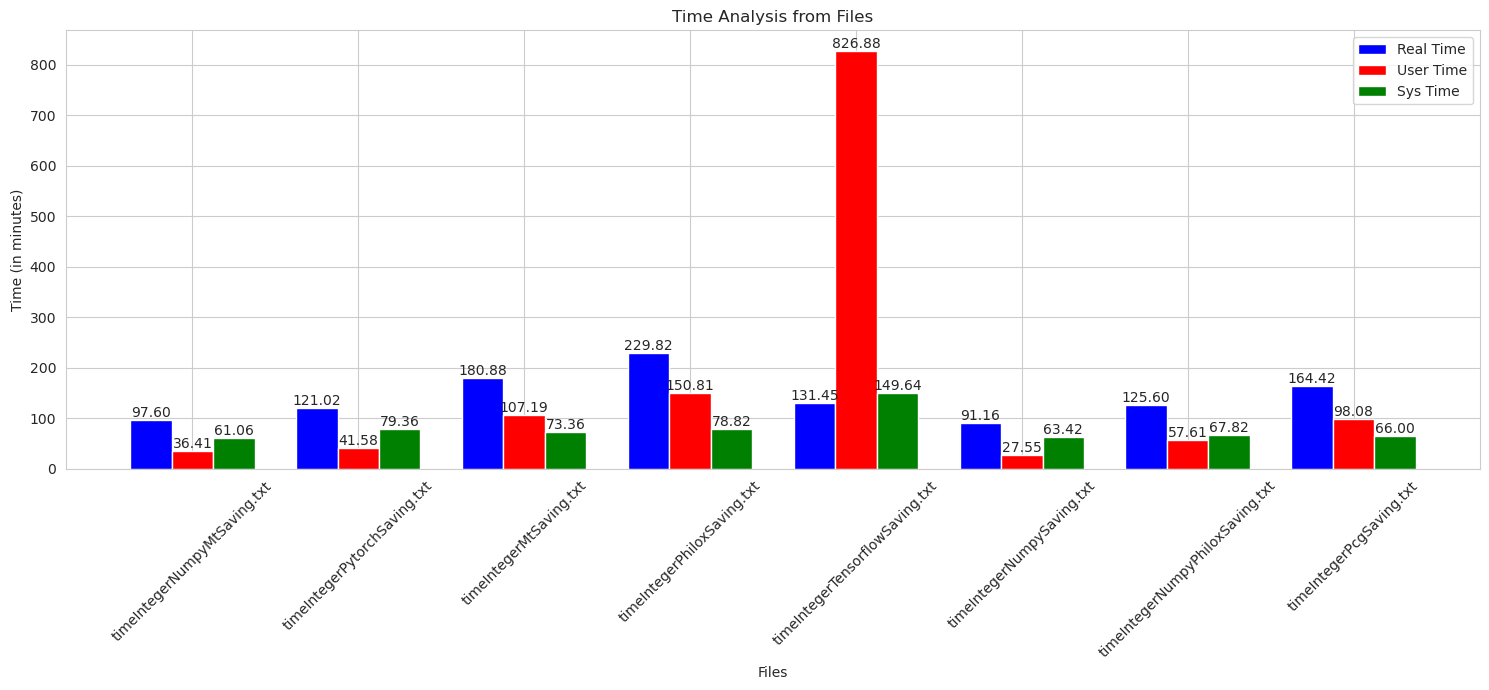

In [31]:
import os
import re
import matplotlib.pyplot as plt

def extract_times(contents):
    real_times = [int(minute) + float(second.replace(',', '.'))/60 for minute, second in re.findall(r'real\s+(\d+)m([\d,]+)s', contents)]
    user_times = [int(minute) + float(second.replace(',', '.'))/60 for minute, second in re.findall(r'user\s+(\d+)m([\d,]+)s', contents)]
    sys_times = [int(minute) + float(second.replace(',', '.'))/60 for minute, second in re.findall(r'sys\s+(\d+)m([\d,]+)s', contents)]
    
    # Assuming that all files have the same format and each time type appears once
    return real_times[0], user_times[0], sys_times[0]

# Find all files starting with "timeInteger"
files = [f for f in os.listdir() if f.startswith("timeInteger") and f != "timeIntegerPythonSaving.txt"]

results = []

for file in files:
    with open(file, 'r') as f:
        content = f.read()  # Reading the entire file as a single string
        real_time, user_time, sys_time = extract_times(content)
        results.append((file, real_time, user_time, sys_time))

# Extract data for plotting
labels = [res[0] for res in results]
real_times = [res[1] for res in results]
user_times = [res[2] for res in results]
sys_times = [res[3] for res in results]

x = range(len(labels))

bar_width = 0.25
r1 = [i for i in x]
r2 = [i + bar_width for i in x]
r3 = [i + 2*bar_width for i in x]

plt.figure(figsize=(15, 7))

plt.bar(r1, real_times, width=bar_width, label='Real Time', align='center', color='b')
plt.bar(r2, user_times, width=bar_width, label='User Time', align='center', color='r')
plt.bar(r3, sys_times, width=bar_width, label='Sys Time', align='center', color='g')

plt.xlabel('Files')
plt.ylabel('Time (in minutes)')
plt.title('Time Analysis from Files')
plt.xticks([r + bar_width for r in r1], labels, rotation=45)
plt.legend()

# Plotting textual values
for i, (real, user, sys) in enumerate(zip(real_times, user_times, sys_times)):
    plt.text(r1[i], real, f"{real:.2f}", ha='center', va='bottom')
    plt.text(r2[i], user, f"{user:.2f}", ha='center', va='bottom')
    plt.text(r3[i], sys, f"{sys:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


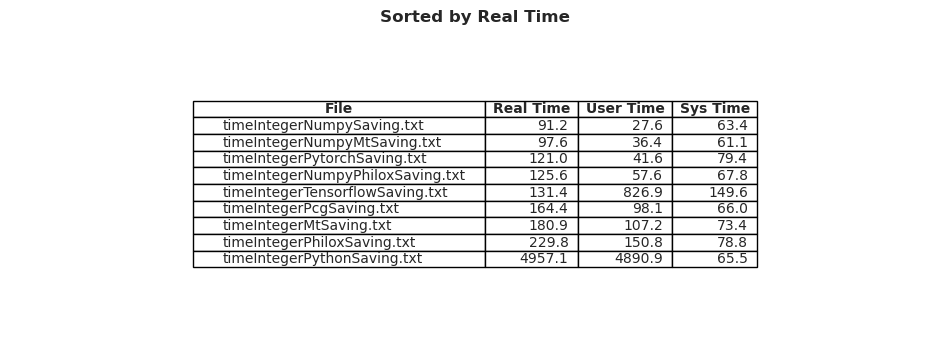

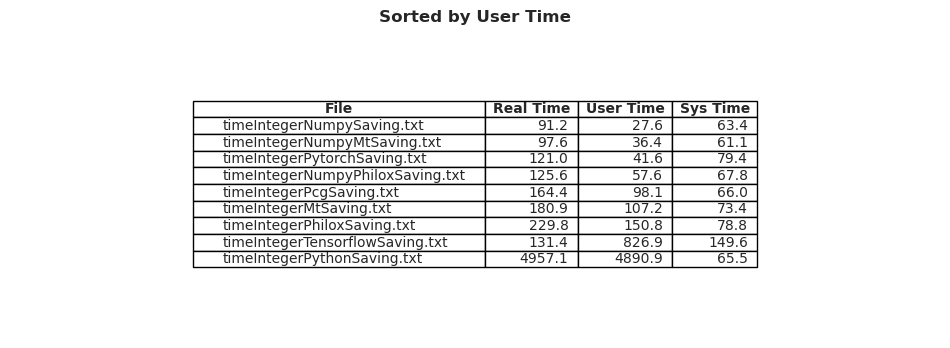

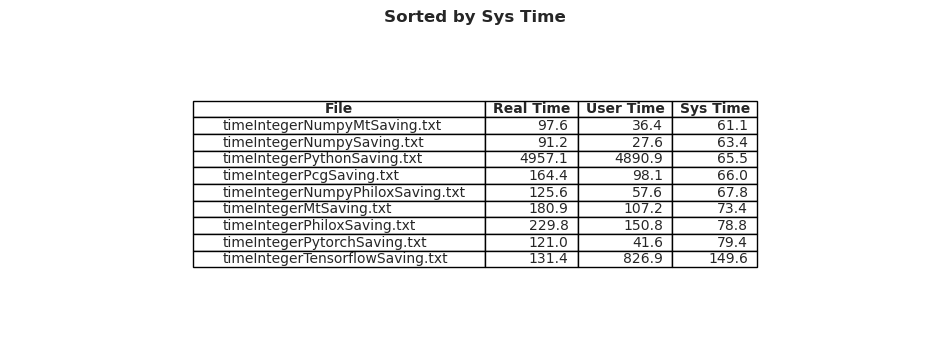

In [3]:
import os
import re
import matplotlib.pyplot as plt
import pandas as pd

def extract_times(contents):
    real_times = [int(minute) + float(second.replace(',', '.'))/60 for minute, second in re.findall(r'real\s+(\d+)m([\d,]+)s', contents)]
    user_times = [int(minute) + float(second.replace(',', '.'))/60 for minute, second in re.findall(r'user\s+(\d+)m([\d,]+)s', contents)]
    sys_times = [int(minute) + float(second.replace(',', '.'))/60 for minute, second in re.findall(r'sys\s+(\d+)m([\d,]+)s', contents)]
    
    return round(real_times[0], 2), round(user_times[0], 2), round(sys_times[0], 2)

# Find all files starting with "timeInteger"
files = [f for f in os.listdir() if f.startswith("timeInteger")]

results = []

for file in files:
    with open(file, 'r') as f:
        content = f.read()
        real_time, user_time, sys_time = extract_times(content)
        results.append((file, real_time, user_time, sys_time))

# Convert results to a Pandas DataFrame
df = pd.DataFrame(results, columns=["File", "Real Time", "User Time", "Sys Time"])

# Function to plot the sorted table
def plot_sorted_table(dataframe, column_name):
    # Sort the dataframe
    sorted_df = dataframe.sort_values(by=column_name)

    # Round numerical values to 3 decimal places if needed
    sorted_df = sorted_df.round(1)
    
    # Save the sorted DataFrame to a CSV file
    csv_filename = f"sorted_by_{column_name.replace(' ', '_')}.csv"
    sorted_df.to_csv(csv_filename, index=False)
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.axis('off')
    
    # Create the table
    table = ax.table(cellText=sorted_df.values, colLabels=sorted_df.columns, loc='center', cellLoc='center')
    
    # Set consistent font size
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    # Adjust column widths
    table.auto_set_column_width(col=list(range(len(sorted_df.columns))))  # set column widths

    # Adjust cell alignment and make headers bold
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Header row
            cell.set_fontsize(10)
            cell.set_text_props(fontweight='bold', ha='center')  # Make headers bold and center-aligned
        elif j == 0:
            cell.set_text_props(ha='left')  # Align left for the first column
        else:
            cell.set_text_props(ha='right')  # Align right for other columns

    # Set title
    plt.title(f'Sorted by {column_name}', fontweight="bold", fontsize=12)

    # Display the plot
    plt.show()

# Plot tables sorted by "Real Time", "User Time", and "Sys Time"
plot_sorted_table(df, "Real Time")
plot_sorted_table(df, "User Time")
plot_sorted_table(df, "Sys Time")
